In [291]:
import torch
import matplotlib.pyplot as plt

In [292]:
class Module:
    def __call__(self, *args):
        return self.forward(*args)

In [293]:
class Dense(Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        std = (2/in_dim)**0.5 #Kaiming initialization
        
        self.weight = torch.randn(in_dim, out_dim) * std
        self.bias = torch.zeros(1, out_dim)

        self.grad_weight = None
        self.grad_bias = None

        self.input = None #forward pass cache
    
    def forward(self, x):
        self.input = x
        return x.matmul(self.weight) + self.bias

    def backward(self, grad_output):
        self.grad_weight = self.input.T.matmul(grad_output)
        self.grad_bias = grad_output.sum(axis=0, keepdims=True)
        grad_input = grad_output.matmul(self.weight.T)
        return grad_input
        

In [294]:
class MLP(Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad


In [321]:
class MSE(Module):
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return ((pred - target) ** 2).mean()

    def backward(self):
        n = self.pred.shape[0]
        return 2.0 * (self.pred - self.target) / n

In [313]:
class ReLU(Module):
    def forward(self, x):
        self.input = x
        return torch.maximum(x, torch.zeros_like(x))

    def backward(self, grad_output):
        relu_grad = (self.input > 0).float()
        return grad_output * relu_grad

In [314]:
class Optimizer:
    def __init__(self, model, learning_rate):
        self.model = model
        self.learning_rate = learning_rate
    
    def step(self):
        raise NotImplementedError

    def zero_grad(self):
        for layer in self.model.layers:
            if isinstance(layer, Dense):
                layer.grad_weight = torch.zeros_like(layer.weight)
                layer.grad_bias = torch.zeros_like(layer.bias)


In [315]:
class GradientDescent(Optimizer):
    def step(self):
        for layer in self.model.layers:
            if isinstance(layer, Dense):
                layer.weight -= layer.grad_weight * self.learning_rate
                layer.bias -= layer.grad_bias * self.learning_rate

In [316]:
class Engine:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.loss_history = []

    def fit(self, X, y, epochs, print_every=10):
        self.loss_history = []
        for epoch in range(epochs):
            pred = self.model(X)

            loss = self.loss_fn(pred, y)
            self.loss_history.append(loss)

            grad = self.loss_fn.backward()
            self.model.backward(grad)
            self.optimizer.step()
            self.optimizer.zero_grad()

            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")
        return self.loss_history

    def plot(self, log_scale=False):
        plt.plot(self.loss_history)
        if log_scale:
            plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()


Epoch 10/100, Loss: 31185.9921875
Epoch 20/100, Loss: 3791.48828125
Epoch 30/100, Loss: 460.9564514160156
Epoch 40/100, Loss: 56.041542053222656
Epoch 50/100, Loss: 6.81334114074707
Epoch 60/100, Loss: 0.8283504843711853
Epoch 70/100, Loss: 0.10070745646953583
Epoch 80/100, Loss: 0.012243487872183323
Epoch 90/100, Loss: 0.00148848257958889
Epoch 100/100, Loss: 0.00018097975407727063


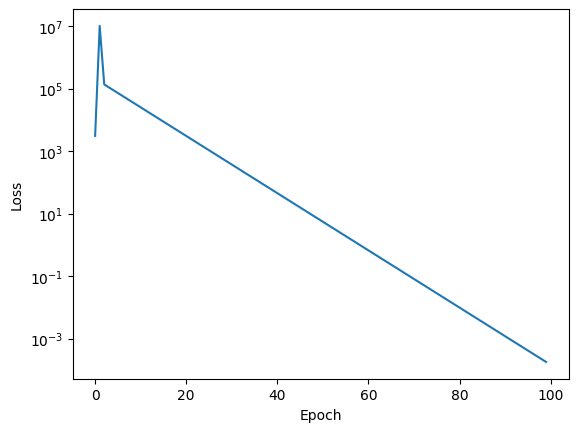

In [329]:
model = MLP([
    Dense(10, 20),
    ReLU(),
    Dense(20, 10),
    ReLU(),
    Dense(10, 2)
])

X = torch.ones(1, 10) 

target = torch.tensor([[42.0, 67.0]])


optimizer = GradientDescent(model, learning_rate=0.05)

train = Engine(model, loss_fn=MSE(), optimizer=optimizer)

train.fit(X, target, epochs=100)

train.plot(log_scale=True)


In [330]:
y = model(X)
print(y)


tensor([[41.9907, 66.9856]])
